<h2>Classification of Advertisements by Means of Supervised Learning Methods</h2>
<h3>Pavlo Mospan - 2020</h3>

### Importing all used libraries, downloading spacy model and preventing warnings from popping up

In [28]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import spacy
nlp = spacy.load('en_core_web_lg')

import re

import warnings
warnings.filterwarnings('ignore')

### Reading a ten 10 topic dataset

In [29]:
df = pd.read_csv('amazon_ten_topic_data.csv', names=['ad'])

# Removing NaN values
df.dropna(inplace=True)

# Shuffling rows
df = df.sample(frac=1)
df.describe()

,ad
count,10000
unique,9934
top,USB Printer with 3 Year Printer Warranty
freq,6


#### Reading only unique values that don't repeat themself

In [30]:
ads = pd.DataFrame(df['ad'].unique(), columns = ['ad'])
ads.head(10)

,ad
0,Lenovo ThinkVision L1900p 19-inch Flat Panel L...
1,Mellewell 14-Inch Single Towel Bar Towel Holde...
2,Kodak 3D Printer Portrait
3,Fox Outdoor Products Large Transport Pack
4,"REEBOK Prisma Sandy Taupe Woman Watch, 34 mm c..."
5,Think! Women's Turna_484041 Low-Top Sneakers
6,"MelonBoat Lotus Cotton Swab Holder, Small Q-Ti..."
7,Ryobi P731 One+ 18v Dual Function Power Inflat...
8,iLive Bluetooth Wireless Headphones with Micro...
9,BlueAnt SP-093801-651 Large Eartips for Q3/Q2/...


### Top words in dataset before feature engineering

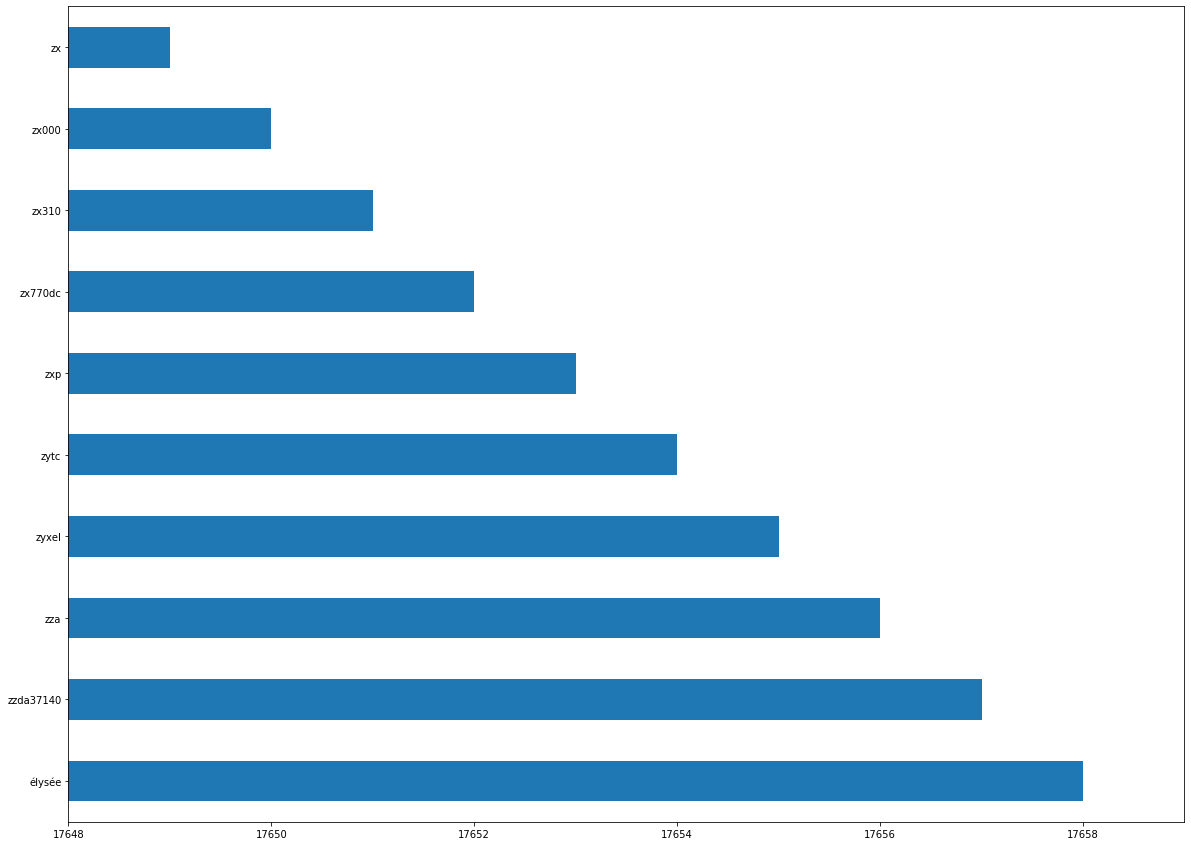

In [36]:
# count vetorizing object
count_vectorizer = CountVectorizer()

# fitting CV
count_vectorizer.fit(ads['ad'])

# collecting the vocabulary items used in vectorizer
dictionary = count_vectorizer.vocabulary_.items()

# Storing vocab and counts in a pandas DF
vocab = []
count = []

# iterating through each vocab and count append the value to designated list
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
    
# storing the count in pandas DF with vocab as index
vocab_bef_stem = pd.Series(count, index = vocab)

# sorting the DF
vocab_bef_stem = vocab_bef_stem.sort_values(ascending=False)

top_vocab = vocab_bef_stem.head(10)
top_vocab.plot(kind = 'barh', figsize=(20, 15), xlim=(17648, 17659))

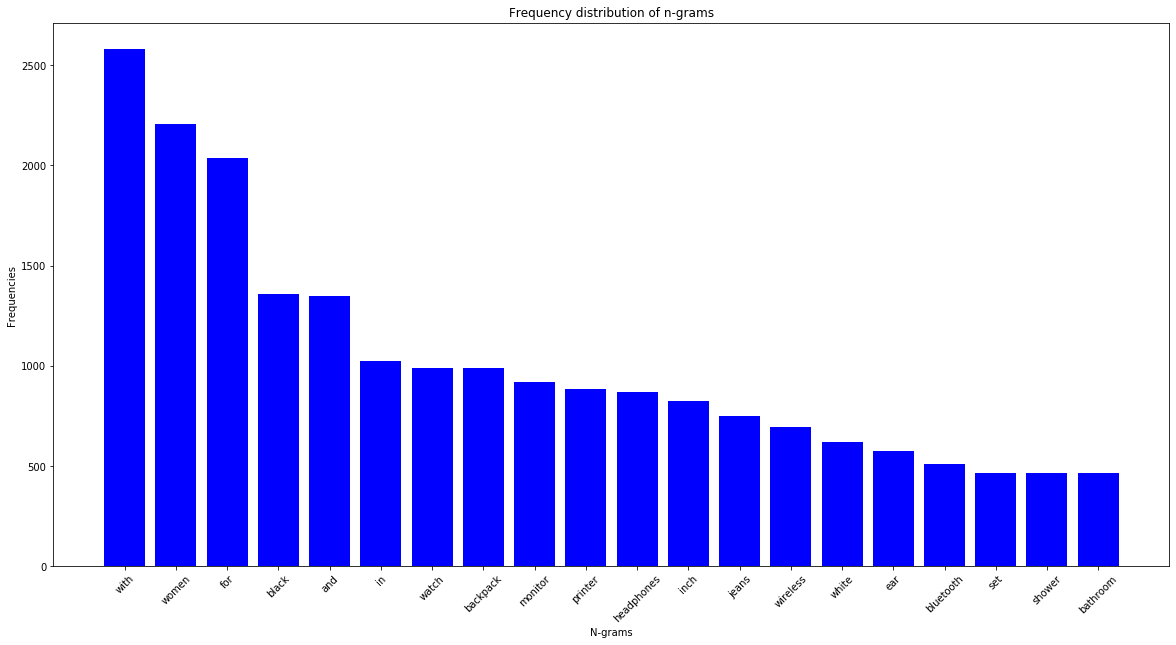

In [37]:
def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 1),
                                          num_ngrams=20):
    """Plots the frequency distribution of n-grams.
    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.figure(figsize=(20,10))
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()
    
    
plot_frequency_distribution_of_ngrams(ads['ad'])

### Visualizing the length of the documents

In [38]:
def length(text):
    """Function that returns the length of a text"""
    return len(text)

In [39]:
ads['len'] = ads['ad'].apply(length)
ads.describe()

,len
count,9934.000000
mean,88.746024
std,47.394857
min,1.000000
25%,52.000000
50%,76.000000
75%,116.000000
max,305.000000


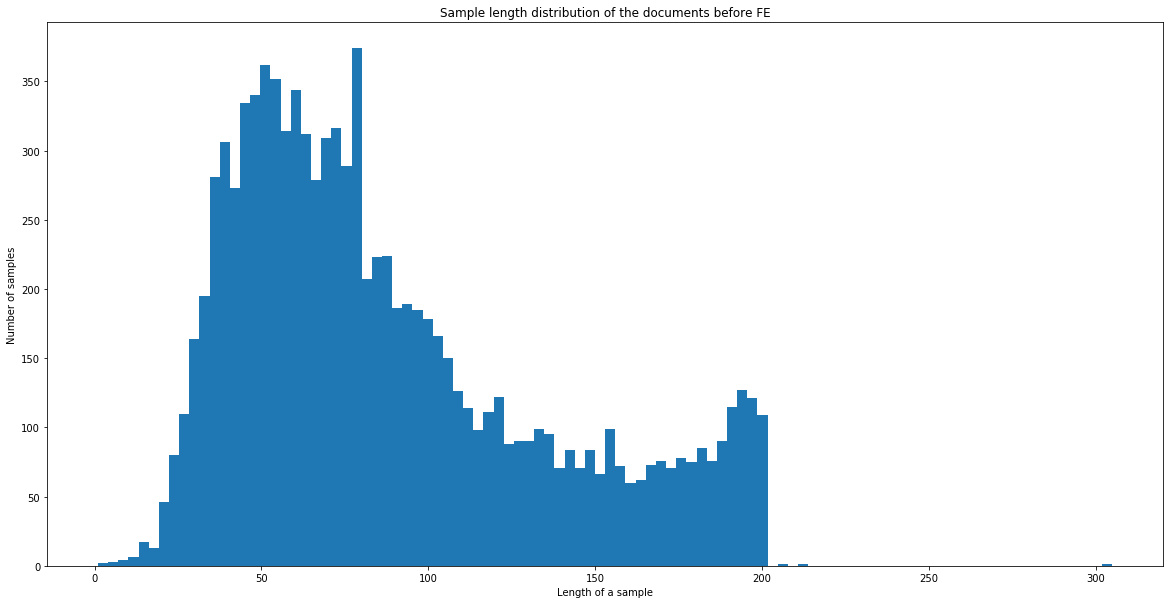

In [40]:
def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    
    plt.figure(figsize=(20,10))
    plt.hist([len(s) for s in sample_texts], 100)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution of the documents before FE')
    plt.show()
    

plot_sample_length_distribution(ads['ad'])

### Removing stopwords

In [41]:
def stopwords(text):
    """
    Function for removing 
        - stopwords,
        - punctuation,
        - numbers / digits
        - words containing numbers
    """
    doc = nlp(text)
    for token in doc:
        text = [token.text for token in doc if 
                not token.is_stop 
                and not token.is_punct 
                and not token.is_digit]
        
        
    # joining the list of words with space separator
    joined_text = " ".join(text)
    # removing words that contain any sort of numbers, like 'G2420-BK' or 'G1W40A#BGJ '
    re_text = re.sub(r"\S*\d\S*", '', joined_text).strip()
    
    return re_text

In [42]:
ads['SW'] = ads['ad'].apply(stopwords)
ads.head()

,ad,len,SW
0,Lenovo ThinkVision L1900p 19-inch Flat Panel L...,79,Lenovo ThinkVision Flat Panel LCD Monitor En...
1,Mellewell 14-Inch Single Towel Bar Towel Holde...,108,Mellewell Single Towel Bar Towel Holder Bathr...
2,Kodak 3D Printer Portrait,25,Kodak Printer Portrait
3,Fox Outdoor Products Large Transport Pack,41,Fox Outdoor Products Large Transport Pack
4,"REEBOK Prisma Sandy Taupe Woman Watch, 34 mm c...",153,REEBOK Prisma Sandy Taupe Woman Watch mm case ...


In [43]:
ads['SW']

0       Lenovo ThinkVision   Flat Panel LCD Monitor En...
1       Mellewell  Single Towel Bar Towel Holder Bathr...
2                                 Kodak  Printer Portrait
3               Fox Outdoor Products Large Transport Pack
4       REEBOK Prisma Sandy Taupe Woman Watch mm case ...
                              ...                        
9929    Laptop Backpack boys Men Women Anti Theft Wate...
9930    Sceptre  HD  LED Monitor HDMI VGA Build Speake...
9931            Skullcandy Navigator ear Headphone  Black
9932             T Shirt Jeans Hugging Cat Backpack Blush
9933                    Levi Women Slimming Straight Jean
Name: SW, Length: 9934, dtype: object

In [44]:
ads['SW'].describe()

count                                   9934
unique                                  9630
top       New Grade LCD Panel  Days Warranty
freq                                      10
Name: SW, dtype: object

In [45]:
ads.describe()

,len
count,9934.000000
mean,88.746024
std,47.394857
min,1.000000
25%,52.000000
50%,76.000000
75%,116.000000
max,305.000000


### 1. Getting rid off of two whitespaces
### 2. Replacing rows with no entries with NaN to dropna them

In [46]:
# 1
ads['SW']=ads['SW'].str.replace("  "," ")

# 2
ads['SW'].replace('', np.nan, inplace=True)
ads.dropna(subset=['SW'], inplace=True)
ads['SW'].describe()

count                                  9932
unique                                 9597
top       New Grade LCD Panel Days Warranty
freq                                     10
Name: SW, dtype: object

In [47]:
ads.describe()

,len
count,9932.000000
mean,88.762787
std,47.384859
min,2.000000
25%,52.000000
50%,76.000000
75%,116.000000
max,305.000000


In [48]:
print(ads)

                                                     ad  len  \
0     Lenovo ThinkVision L1900p 19-inch Flat Panel L...   79   
1     Mellewell 14-Inch Single Towel Bar Towel Holde...  108   
2                             Kodak 3D Printer Portrait   25   
3             Fox Outdoor Products Large Transport Pack   41   
4     REEBOK Prisma Sandy Taupe Woman Watch, 34 mm c...  153   
...                                                 ...  ...   
9929  Laptop Backpack for boys & Men & Women,Anti Th...  200   
9930  Sceptre 24" 75Hz Full HD 1080P LED Monitor HDM...  104   
9931  Skullcandy Navigator On-ear Headphone with Mic...   54   
9932      T-Shirt & Jeans Hugging Cat Backpack in Blush   45   
9933              Levi's Women's Slimming Straight Jean   37   

                                                     SW  
0     Lenovo ThinkVision  Flat Panel LCD Monitor Ene...  
1     Mellewell Single Towel Bar Towel Holder Bathro...  
2                                Kodak Printer Portrait  

### Top words in dataset after FE

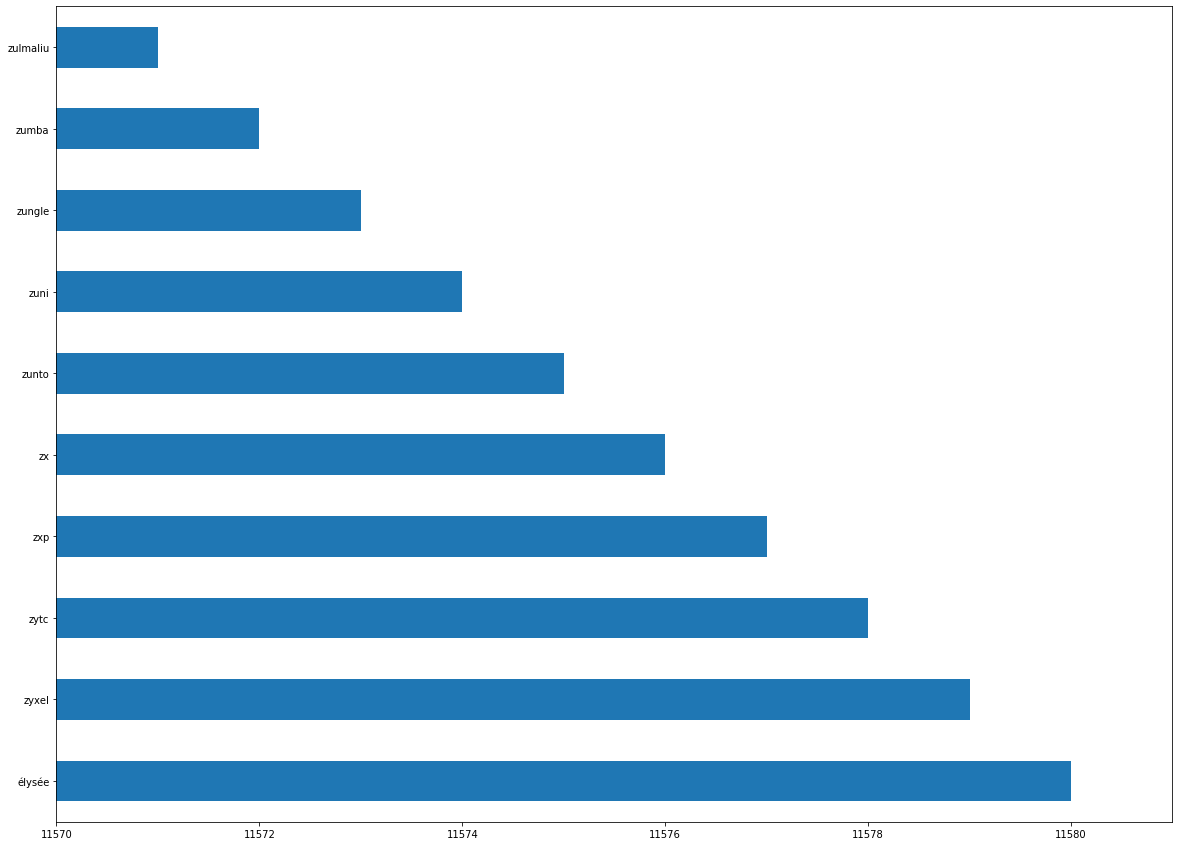

In [57]:
# count vetorizing object
count_vectorizer = CountVectorizer()

# fitting CV
count_vectorizer.fit(ads['SW'])

# collecting the vocabulary items used in vectorizer
dictionary = count_vectorizer.vocabulary_.items()

# Storing vocab and counts in a pandas DF
vocab = []
count = []

# iterating through each vocab and count append the value to designated list
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
    
# storing the count in pandas DF with vocab as index
vocab_bef_stem = pd.Series(count, index = vocab)

# sorting the DF
vocab_bef_stem = vocab_bef_stem.sort_values(ascending=False)

top_vocab = vocab_bef_stem.head(10)
top_vocab.plot(kind = 'barh', figsize=(20, 15), xlim=(11570, 11581))

### FE in action

In [50]:
print(ads['ad'][9596], ' ====', ads['SW'][9596])

LABELMATE UCAT-3-CHUCK-220 Label Unwinder, 13" Height, 12" Width, Black  ==== LABELMATE Label Unwinder Height Width Black


In [60]:
print(len(ads['ad'][8]), ' ====', ads['ad'][8])

60  ==== iLive Bluetooth Wireless Headphones with Microphone (iAHB6B)


In [61]:
print(len(ads['SW'][8]), ' ====', ads['SW'][8])

46  ==== iLive Bluetooth Wireless Headphones Microphone


# WORD VECTORS

## Identifying similar vectors in each document
The best way to expose vector relationships is through the `.similarity()` method of Doc tokens.

In [20]:
# removing multiple occurances
def remove_occ(duplicate):
    """
    Function for removing multiple occurances of the same word vectors
    """
    test_for_occurancies = []
    final_sim = [] 

    for num in duplicate: 
        if num[2] not in test_for_occurancies: 
            test_for_occurancies.append(num[2])
            final_sim.append(num) 
    return final_sim

In [21]:
def word_vectors(text):
    global cc
    tokens = nlp(text)
    
    # list of simular vectors - each word compared with one another to present a similuraity probability
    sims = []
    # counts number of words i.e. tokens in document
    counter = 0
    
    # Iterate through token combinations:
    for token1 in tokens:
        counter += 1
        for token2 in tokens:
            sims.append([token1.text, token2.text, token1.similarity(token2)])
    
    
    # sorting by similarity for better value manipulation later on
    sorted_sims = sorted(sims, key=lambda sim: sim[2], reverse=True)
    
    # removing vectors with  a perfect (1.0) similarity 
    for sim in sorted_sims:
        if sim[2] == 1.0:
            sorted_sims.remove(sim)
            
            
    # word vector with no perfect simularities and duplicates
    word_vector = remove_occ(sorted_sims)
    
    """ 
    taking only first few words out of all of them
    deciding on feaure: len(word_vector)/counter)
    for instance 36 / 9 = 4
    """
    test_for_occurancies = []
    final_words = []

    for i in range(int(len(word_vector)/counter)):
        if word_vector[i][0] not in test_for_occurancies: 
            test_for_occurancies.append(word_vector[i][0])
            final_words.append(word_vector[i][0])
        if word_vector[i][1] not in test_for_occurancies:
            test_for_occurancies.append(word_vector[i][1])
            final_words.append(word_vector[i][1])

    return(final_words)

In [22]:
ads['word_vectors'] = ads['SW'].apply(word_vectors)

In [23]:
ads

,ad,len,SW,word_vectors
0,KYBOE! Power Stainless Steel Quartz Watch with...,93,KYBOE Power Stainless Steel Quartz Watch Silic...,"[Power, Stainless, Steel, Quartz]"
1,"Sceptre C275B-144MN 27"" Curved 144Hz Gaming LE...",138,Sceptre Curved Gaming LED Monitor AMD FreeSync...,"[Curved, HDMI, DVI, DisplayPort, Curvature, AMD]"
2,"CRAFTSMAN Adjustable Wrench, 10-Inch (CMMT81623)",48,CRAFTSMAN Adjustable Wrench,[Adjustable]
3,Buxton Men's Bowtie Drawstring Bucket Backpack...,62,Buxton Men Bowtie Drawstring Bucket Backpack B...,"[Men, Drawstring, Backpack, Bucket]"
4,CURT 28112 Marine Boat Trailer Jack with 6-Inc...,90,CURT Marine Boat Trailer Jack Wheel lbs Inches...,"[Marine, lbs, Inches, Boat, Jack, Wheel]"
...,...,...,...,...
9929,Ladies Sekonda Editions Watch 2327,34,Ladies Sekonda Editions Watch,[Sekonda]
9930,NYDJ Women's Dylan Skinny Ankle in Modern Edit...,69,NYDJ Women Dylan Skinny Ankle Modern Edit Fit ...,"[Women, Skinny, Denim, Fit, Sure, Ankle, Stretch]"
9931,Arisen Phantom Bluetooth Headphones [Deep Bass...,195,Arisen Phantom Bluetooth Headphones Deep Bass ...,"[Phantom, Earbuds, Earphones, Headphones, Head..."
9932,Burton Harbor 4 Piece Bath Hardware Accessorie...,114,Burton Harbor Piece Bath Hardware Accessories ...,"[Harbor, Toilet, Towel, Bath, Piece, Paper, Ha..."


# NMF

In [64]:
ads.head()

,ad,len,SW
0,Lenovo ThinkVision L1900p 19-inch Flat Panel L...,79,Lenovo ThinkVision Flat Panel LCD Monitor Ene...
1,Mellewell 14-Inch Single Towel Bar Towel Holde...,108,Mellewell Single Towel Bar Towel Holder Bathro...
2,Kodak 3D Printer Portrait,25,Kodak Printer Portrait
3,Fox Outdoor Products Large Transport Pack,41,Fox Outdoor Products Large Transport Pack
4,"REEBOK Prisma Sandy Taupe Woman Watch, 34 mm c...",153,REEBOK Prisma Sandy Taupe Woman Watch mm case ...


In [62]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

dtm = tfidf.fit_transform(ads['SW'])

dtm

<9932x5535 sparse matrix of type '<class 'numpy.float64'>'
	with 96462 stored elements in Compressed Sparse Row format>

In [63]:
dtm.shape

(9932, 5535)

In [65]:
nmf_model = NMF(n_components=10,random_state=42)

# This can take awhile, we're dealing with a large amount of documents!
nmf_model.fit(dtm)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=10, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [66]:
len(tfidf.get_feature_names())

5535

In [67]:
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['black', 'ladies', 'dial', 'gold', 'womens', 'women', 'analog', 'analogue', 'model', 'leather', 'stainless', 'steel', 'strap', 'quartz', 'watch']


THE TOP 15 WORDS FOR TOPIC #1
['wired', 'sports', 'black', 'microphone', 'headset', 'cancelling', 'stereo', 'mic', 'earphones', 'noise', 'earbuds', 'wireless', 'ear', 'bluetooth', 'headphones']


THE TOP 15 WORDS FOR TOPIC #2
['gaming', 'lg', 'inch', 'display', 'acer', 'vga', 'lit', 'dell', 'hd', 'ips', 'hdmi', 'screen', 'led', 'lcd', 'monitor']


THE TOP 15 WORDS FOR TOPIC #3
['size', 'straight', 'womens', 'waist', 'mid', 'stretch', 'ankle', 'pants', 'jean', 'high', 'denim', 'rise', 'women', 'skinny', 'jeans']


THE TOP 15 WORDS FOR TOPIC #4
['duplex', 'mobile', 'scanner', 'copier', 'pixma', 'printing', 'monochrome', 'inkjet', 'lexmark', 'laser', 'wireless', 'color', 'canon', 'photo', 'printer']


THE TOP 15 WORDS FOR TOPIC #5
['canvas', 'charging', 'business', 'usb', 'bookbag', 'black', 'college', 'daypack',

In [68]:
topic_results = nmf_model.transform(dtm)

ads.head()

,ad,len,SW
0,Lenovo ThinkVision L1900p 19-inch Flat Panel L...,79,Lenovo ThinkVision Flat Panel LCD Monitor Ene...
1,Mellewell 14-Inch Single Towel Bar Towel Holde...,108,Mellewell Single Towel Bar Towel Holder Bathro...
2,Kodak 3D Printer Portrait,25,Kodak Printer Portrait
3,Fox Outdoor Products Large Transport Pack,41,Fox Outdoor Products Large Transport Pack
4,"REEBOK Prisma Sandy Taupe Woman Watch, 34 mm c...",153,REEBOK Prisma Sandy Taupe Woman Watch mm case ...


In [69]:
ads['NMF Topic'] = topic_results.argmax(axis=1)

my_topic_dictionary = {0: 'Watches', 
                       1: 'Headphones', 
                       2: 'Monitor', 
                       3: 'Jeans', 
                       4: 'Scanner', 
                       5: 'Backpack', 
                       6: 'Sneaker',
                       7: 'Bath', 
                       8: 'Printer', 
                       9: 'Tires & Wheels'}

ads['NMF Topic Label'] = ads['NMF Topic'].map(my_topic_dictionary)
ads

,ad,len,SW,NMF Topic,NMF Topic Label
0,Lenovo ThinkVision L1900p 19-inch Flat Panel L...,79,Lenovo ThinkVision Flat Panel LCD Monitor Ene...,2,Monitor
1,Mellewell 14-Inch Single Towel Bar Towel Holde...,108,Mellewell Single Towel Bar Towel Holder Bathro...,7,Bath
2,Kodak 3D Printer Portrait,25,Kodak Printer Portrait,4,Scanner
3,Fox Outdoor Products Large Transport Pack,41,Fox Outdoor Products Large Transport Pack,5,Backpack
4,"REEBOK Prisma Sandy Taupe Woman Watch, 34 mm c...",153,REEBOK Prisma Sandy Taupe Woman Watch mm case ...,0,Watches
...,...,...,...,...,...
9929,"Laptop Backpack for boys & Men & Women,Anti Th...",200,Laptop Backpack boys Men Women Anti Theft Wate...,5,Backpack
9930,"Sceptre 24"" 75Hz Full HD 1080P LED Monitor HDM...",104,Sceptre HD LED Monitor HDMI VGA Build Speakers...,2,Monitor
9931,Skullcandy Navigator On-ear Headphone with Mic...,54,Skullcandy Navigator ear Headphone Black,1,Headphones
9932,T-Shirt & Jeans Hugging Cat Backpack in Blush,45,T Shirt Jeans Hugging Cat Backpack Blush,5,Backpack


# Nearest Neighbors Search

In [70]:
knn = NearestNeighbors(n_neighbors=10, metric='cosine')
knn.fit(dtm)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [71]:
knn.kneighbors(dtm[0:1], return_distance=False)

array([[   0, 7307, 3900, 5343, 6711,  448,  491, 3236, 5798, 5519]])

In [72]:
knn.kneighbors(dtm[0:1], return_distance=True)

(array([[0.        , 0.20371575, 0.35733443, 0.35733443, 0.41925997,
         0.4196472 , 0.43221593, 0.48422298, 0.49529006, 0.54552562]]),
 array([[   0, 7307, 3900, 5343, 6711,  448,  491, 3236, 5798, 5519]]))

In [87]:
input_ad = ['Canon CanoScan Lide 300 Scanner',
            "Puma 19.5"" The Pace Backpack - Camouflage/Orange with Laptop Sleeve Back Pack",
            "Floto Luggage Tack Italian Duffle, Tuscan Red, Medium",]
input_features = tfidf.transform(input_ad)

In [88]:
D, N = knn.kneighbors(input_features, n_neighbors=1, return_distance=True)

for input_text, distances, neighbors in zip(input_ad, D, N):
    print("INPUT TEXT = ", input_text[:200], "\n\n")
    for dist, neighbor_idx in zip(distances, neighbors):
        print("Distance = ", dist, "Neighbor idx = ", neighbor_idx)
        print('TOPIC : ', ads['NMF Topic Label'][neighbor_idx])
        print('EXAMPLE TEXT', ads['SW'][neighbor_idx][:200])
        print("-"*100)
    print("="*100)
    print()

INPUT TEXT =  Canon CanoScan Lide 300 Scanner 


Distance =  0.33004350698912766 Neighbor idx =  2167
TOPIC :  Scanner
EXAMPLE TEXT Promaster Speedlight Transceiver Canon
----------------------------------------------------------------------------------------------------

INPUT TEXT =  Puma 19.5 The Pace Backpack - Camouflage/Orange with Laptop Sleeve Back Pack 


Distance =  0.6494704517571954 Neighbor idx =  5056
TOPIC :  Backpack
EXAMPLE TEXT PUMA Men Aesthetic Backpack
----------------------------------------------------------------------------------------------------

INPUT TEXT =  Floto Luggage Tack Italian Duffle, Tuscan Red, Medium 


Distance =  0.6321381813379148 Neighbor idx =  5421
TOPIC :  Backpack
EXAMPLE TEXT Armour Backpack Duffle Large Bag
----------------------------------------------------------------------------------------------------



# Random Forest

In [75]:
from sklearn import pipeline, ensemble, preprocessing, feature_extraction, metrics

In [76]:
clf = pipeline.Pipeline([
    ('tfidf_vectorizer', feature_extraction.text.TfidfVectorizer(lowercase=True)),
    ('rf_classifier', ensemble.RandomForestClassifier(n_estimators=500, verbose=1, n_jobs=1))
])

In [77]:
X_train, X_test, y_train, y_test = train_test_split(ads['SW'], ads['NMF Topic'], test_size=0.3)

In [78]:
clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    9.5s finished


Pipeline(memory=None,
         steps=[('tfidf_vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 toke...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                               

In [79]:
y_pred = clf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished


In [80]:
metrics.confusion_matrix(y_test, y_pred)

array([[268,   1,   0,   0,   0,   0,   0,  12,   0,   0],
       [  0, 275,   0,   0,   0,   0,   0,   2,   0,   0],
       [  0,   0, 302,   0,   1,   0,   0,   6,   0,   2],
       [  0,   0,   0, 296,   0,   1,   2,   5,   0,   1],
       [  0,   1,   0,   0, 196,   0,   0,   2,   2,   2],
       [  0,   0,   0,   0,   1, 294,   2,   7,   0,   1],
       [  7,   0,   0,   9,   0,   0, 317,   3,   0,   1],
       [  0,   1,   1,   0,   0,   2,   1, 557,   0,  10],
       [  0,   1,   2,   0,   0,   1,   0,   0,  57,   0],
       [  2,   4,   2,   1,   0,   1,   6,  18,   0, 294]])

In [81]:
metrics.accuracy_score(y_test, y_pred)

0.9583892617449664

In [82]:
ads

,ad,len,SW,NMF Topic,NMF Topic Label
0,Lenovo ThinkVision L1900p 19-inch Flat Panel L...,79,Lenovo ThinkVision Flat Panel LCD Monitor Ene...,2,Monitor
1,Mellewell 14-Inch Single Towel Bar Towel Holde...,108,Mellewell Single Towel Bar Towel Holder Bathro...,7,Bath
2,Kodak 3D Printer Portrait,25,Kodak Printer Portrait,4,Scanner
3,Fox Outdoor Products Large Transport Pack,41,Fox Outdoor Products Large Transport Pack,5,Backpack
4,"REEBOK Prisma Sandy Taupe Woman Watch, 34 mm c...",153,REEBOK Prisma Sandy Taupe Woman Watch mm case ...,0,Watches
...,...,...,...,...,...
9929,"Laptop Backpack for boys & Men & Women,Anti Th...",200,Laptop Backpack boys Men Women Anti Theft Wate...,5,Backpack
9930,"Sceptre 24"" 75Hz Full HD 1080P LED Monitor HDM...",104,Sceptre HD LED Monitor HDMI VGA Build Speakers...,2,Monitor
9931,Skullcandy Navigator On-ear Headphone with Mic...,54,Skullcandy Navigator ear Headphone Black,1,Headphones
9932,T-Shirt & Jeans Hugging Cat Backpack in Blush,45,T Shirt Jeans Hugging Cat Backpack Blush,5,Backpack
